# Art Generation Using Neural Network

In [1]:
import os
import numpy as np
import tensorflow as tf
import keras.layers as tfl
import keras
from PIL import Image
import matplotlib.pyplot as plt

### Load the model

In [3]:
img_size = 400

vgg = tf.keras.applications.VGG19(
    include_top=False,
    input_shape=(img_size, img_size, 3),
    weights='/home/abdalla/Datasets/art/pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False

### Create helper functions

In [6]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Inputs:
        a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
        a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
        J_content -- scalar that you compute using equation 1 above.
    """
    
    a_C = content_output[-1]
    a_G = generated_output[-1]
        
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G
    a_C_unrolled = tf.reshape(a_C, shape = [m, n_C, n_H * n_W])
    a_G_unrolled = tf.reshape(a_G, shape = [m, n_C, n_H * n_W])
    
    # compute the cost with tensorflow
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C, a_G)), axis = None) / (4 * n_H * n_W * n_C)
        
    return J_content

In [7]:
def gram_matrix(A):
    """
    Inputs:
        A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
        GA -- Gram matrix of A, of shape (n_C, n_C)
    """  
    
    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

In [8]:
def compute_layer_style_cost(a_S, a_G):
    """
    Inputs:
        a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
        a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
        J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W)
    a_S = tf.transpose(tf.reshape(a_S, [n_H * n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H * n_W, n_C]))

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG)), axis = None) / (4 * (n_H * n_W) ** 2 * n_C ** 2)
        
    return J_style_layer

In [9]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [10]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The first element of the array contains the input layer image, which must not to be used.
    a_S = style_image_output[1:]

    # Set a_G to be the output of the choosen hidden layers.
    # The First element of the list contains the input layer image which must not to be used.
    a_G = generated_image_output[1:]
    
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

In [11]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha * J_content + beta * J_style
    
    return J

In [22]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [29]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [30]:
def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

### Load style and content images

(1, 400, 400, 3)


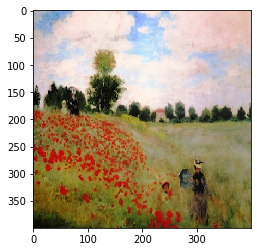

In [17]:
style_image =  np.array(Image.open("/home/abdalla/Datasets/art/images/monet.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
plt.imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


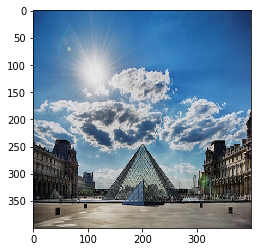

In [15]:
content_image = np.array(Image.open("/home/abdalla/Datasets/art/images/louvre_small.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
plt.imshow(content_image[0])
plt.show()


### Initialize image to be be generated

(1, 400, 400, 3)


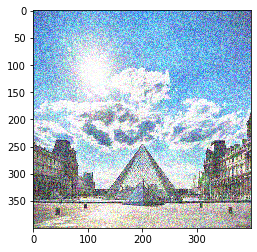

In [21]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.5)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
plt.imshow(generated_image.numpy()[0])
plt.show()

In [23]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [24]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

In [26]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input.
a_G = vgg_model_outputs(generated_image)

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

print(J_content)

tf.Tensor(0.008031108, shape=(), dtype=float32)


In [28]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

# Compute the style cost
J_style = compute_style_cost(a_S, a_G)
print(J_style)

tf.Tensor(601.2323, shape=(), dtype=float32)


In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
     
        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G)

        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        
        # Compute the total cost
        J = total_cost(J_content, J_style, alpha = 10, beta = 40)
        
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    return J


In [32]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

Epoch 0 


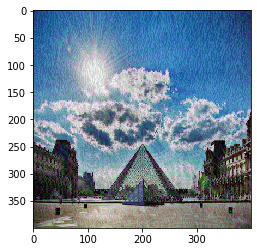

Epoch 250 


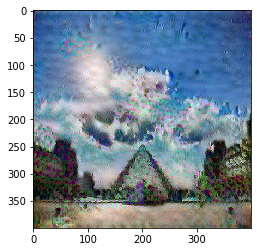

In [ ]:
epochs = 1501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        plt.imshow(image)
        image.save(f"artOut/image_{i}.jpg")
        plt.show()

# DONE :D